In [1]:
## Idenitfy how many pixels need to be avergaed until mean converges to a steady value.

# 1. identify sample SPOTS in raster scene as polygons
# 2. mask raster to only show data within these polygonns
# 3. extract individual pixel values for given Band/wavelength
# 4. sort pixels randomly
# 5. iterativly calculate mean spectral value as pixels are added one at a time. 
# 6. identify number of pixels where mean spectral value begins to stabalize. This is the minimum number of pixels needed to charectorize a targeted surface.
# 7. Conver minimum number of pixels to minimum number of SPOT polygons at the 50-meter, 100-meter, and 150-meter radius (e.g. 9 pixels, 20 pixels, and X pixels each)

In [2]:
# load libraries

import geopandas as gpd
import rasterio as rio
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.mask import mask
import rasterstats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from os import path
from shapely.geometry import box

# identify working directories for exports
current_dir = os.getcwd() # current directory for scripts/git
parent_dir = os.path.dirname(current_dir) # one level up for exports
parent_dir = os.path.dirname(parent_dir)

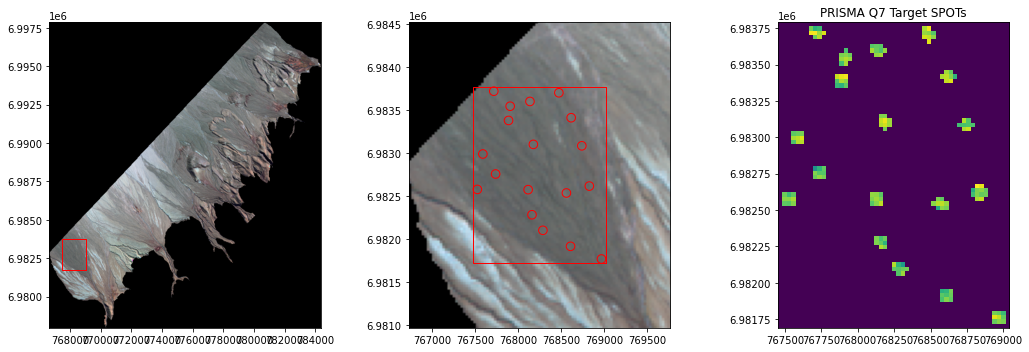

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': 0.0,
 'width': 591,
 'height': 663,
 'count': 234,
 'crs': CRS.from_epsg(32719),
 'transform': Affine(29.99981, 0.0, 766641.15,
        0.0, -30.0, 6997860.133)}

In [92]:
### LOCATE TARGET FILES ### (*manual*)
polygons_file = r'C:\Users\htccr\Documents\Aconquija\GIS_data\testing\test_spots_Q7_clean.shp'
target_data_file = r'C:\Users\htccr\Documents\Aconquija\imagery\prisma\PRS_L2D_STD_20210815143130_20210815143134_0001\exports\clipped\PRIMSA_20210815_stack_ortho_clip-surfaces_BCET.tif'
sensor = 'PRISMA'

## READ IN FILES
# Multiband Raster
data_src = rio.open(target_data_file, 'r')
data_profile = data_src.profile
count = data_profile['count'] # How many bands are in our image?

# RGB raster (for plotting)
rgb_file = parent_dir + '\outputs\\aconquija_Landsat642.tif' # use 'RGB_composite.ipynb' to create RGB
rgb_src = rio.open(rgb_file, 'r')

# Polygons i.e Spots
polygons = gpd.read_file(polygons_file)

# create Geodataframe feature of polygons full extent (for plotting)
bbox_polygons = box(*polygons.total_bounds)
bbox_polygons = gpd.GeoDataFrame({"id":1,"geometry":[bbox_polygons]}) # create Geodataframne of the total extent of the polygon shapefile (for plotting)
extent_polygons = np.array(polygons.total_bounds) # extract numerical values for the polygons total extent (for plotting)

# mask and keep only pixels within polygons
masked, mask_transform = mask(dataset=data_src, shapes=polygons.geometry, crop=True, all_touched  = False, nodata = data_profile['nodata']) # mask pixs not within polygons i.e. Spots

## MOE MINUM N function
# function to determine minimum number (n) pixels to reach a designated Margin of Error given a specific confident interval (z score)
def margin_of_error(z, std, MOE):
    n_required = ((z*std)/MOE)**2
    return(n_required)

z = 1.96 # i.e 95% confidence interval (*manual*)
MOE = 250 # reflectance (*manual*)


## PLOT AND CHECK
saveIt = 0

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15,5))

show(rgb_src, ax = ax1)
bbox_polygons.plot(ax = ax1, facecolor = 'none', edgecolor = 'red')

show(rgb_src, ax = ax2)
bbox_polygons.plot(ax = ax2, facecolor = 'none', edgecolor = 'red')
polygons.plot(ax = ax2, facecolor = 'none', edgecolor = 'red')
ax2.set_xlim(extent_polygons[0] - 750, extent_polygons[2]+ 750)
ax2.set_ylim(extent_polygons[1] - 750, extent_polygons[3]+ 750)

show(masked[0], transform = mask_transform, ax = ax3) # optionally trasnform into geospatial coordinates, from mask meta. Plotting band 1 pix

plt.title('{} Q7 Target SPOTs'.format(sensor))
plt.tight_layout()
plt.show()

if saveIt:
    plt.savefig(parent_dir + '\outputs\\pix_converge_Q7_random.tif') # (*manual*)
    
plt.show()

# image metadata
data_src.meta

Minimum n pix to reach a MOE of 250 with z score of 1.96 is: 243.0 pixels
Based on MOE - At least 27.0 50-meter spots, or 12.2 100-meter spots are needed


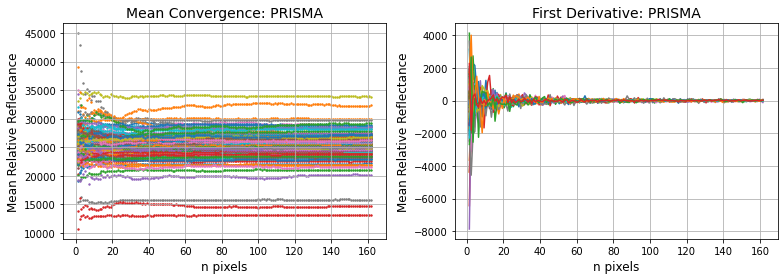

In [93]:
### EXTRACT PIXEL VALUES BY BAND ###
count_pix = masked[1][masked[1] != data_profile['nodata']] # get number of non- nodata pixels in the first band, use as numpy shape
count_pix = np.min(np.shape(count_pix))

# Create empty arrays to populate with data
x_array = np.empty((count, count_pix))
y_array = np.empty((count, count_pix))

x_p_array = np.empty((count, count_pix - 1))
y_p_array = np.empty((count, count_pix - 1))

MOE_outputs = []

# calculate zonal statistics    
for i in range(count):
    pix = masked[i] # choose band to get values from
    pix = masked[i][masked[i] != data_profile['nodata']] # remove all 'nodata' values from array i.e. 0
    
    # calulate stats
    mean_pix = pix.mean()
    max_pix = pix.max()
    min_pix = pix.min()
    std_pix = pix.std()
    count_pix_temp = np.min(np.shape(pix))
    
    # iterate through pixels and store cumulative means
    np.random.shuffle(pix) # randomly sort pixel values
    pixel = np.arange(1,count_pix + 1, 1) # create list of pixels 1 to max. x-variable
    means = [] # empty list to iterativy fill
    
    for kk in range(count_pix):
        means.append(np.mean(pix[0:kk+1])) # calulate means iterativly i.e. y1 = (n1)/1; y2 = (n1 + n2)/2; y3 = (n1 + n2 + n3)/3 ...

    
    # STORE DATA
    x = pixel 
    y = means
    x_array[i] = x
    y_array[i] = y
    
    # approximate first derivative i.e. slope of line at midpoiont between two points
    x_p = (np.array(x)[:-1] + np.array(x)[1:]) / 2
    y_p = np.diff(y) / np.diff(x)
    x_p_array[i] = x_p
    y_p_array[i] = y_p
    
    # MOE
    n_pix_required = margin_of_error(z,std_pix, MOE)
    MOE_outputs.append(n_pix_required)
    

## PLOT 

saveIt = 0  # (*manual*) 1 = save figure

plt.figure(figsize=(11,4))

# plot cumulative means by pixel
plt.subplot(1,2,1)

for k in range(0, count):
    plt.scatter(x_array[k], y_array[k], s = 2, label = 'B{}'.format(k + 1))

plt.xlabel('n pixels', size = 12)
plt.ylabel('Mean Relative Reflectance', size = 12)
plt.title('Mean Convergence: {}'.format(sensor), size = 14)
plt.grid()
plt.ylim()
#plt.legend()

# plot first derivative, should converge at 0
plt.subplot(1,2,2)
for k in range(0, count):
    plt.plot(x_p_array[k], y_p_array[k], label = 'B{}'.format(k + 1))

plt.xlabel('n pixels', size = 12)
plt.ylabel('Mean Relative Reflectance', size = 12)
plt.title('First Derivative: {}'.format(sensor), size = 14)
plt.grid()
plt.ylim()
#plt.legend()

plt.tight_layout()

if saveIt:
    plt.savefig(parent_dir + '\outputs\\figures\pix_converge_Q7_target.png')

MOE_outputs_avg = round(np.mean(MOE_outputs), 0)
print('Minimum n pix to reach a MOE of {} with z score of {} is: {} pixels'.format(MOE,z,MOE_outputs_avg))

converge = MOE_outputs_avg
spots_50m = round(converge/9, 1)
spots_100m = round(converge/20, 1)

print('Based on MOE - At least {} 50-meter spots, or {} 100-meter spots are needed'.format(spots_50m,spots_100m))


Minimum n pix to reach a MOE of 250 with z score of 1.96 is: 81 pixels


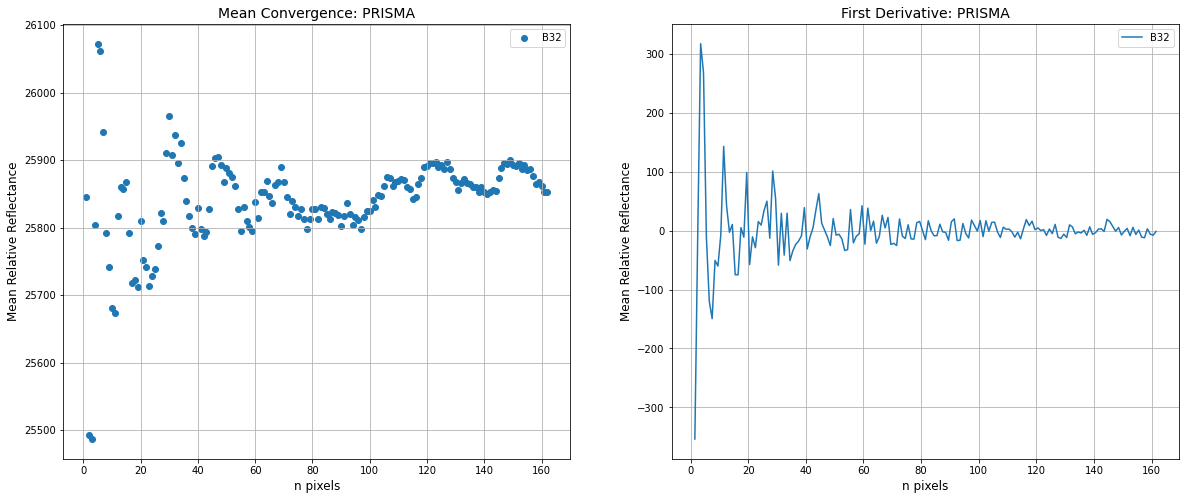

In [67]:
## PLOT INDIVIDUAL BAND ##

target_band = 32 # band to plot, starting at 1

## PLOT 
target_band = target_band + 1
plt.figure(figsize=(20,8))

# plot cumulative means by pixel
plt.subplot(1,2,1)
plt.scatter(x_array[target_band], y_array[target_band], label = 'B{}'.format(target_band-1))

plt.legend()
plt.xlabel('n pixels', size = 12)
plt.ylabel('Mean Relative Reflectance', size = 12)
plt.title('Mean Convergence: {}'.format(sensor), size = 14)
plt.grid()
plt.ylim()

# plot first derivative, should converge at 0
plt.subplot(1,2,2)
plt.plot(x_p_array[target_band], y_p_array[target_band], label = 'B{}'.format(target_band-1))

plt.legend()
plt.xlabel('n pixels', size = 12)
plt.ylabel('Mean Relative Reflectance', size = 12)
plt.title('First Derivative: {}'.format(sensor), size = 14)
plt.grid()
plt.ylim()

MOE_target_band = round(MOE_outputs[target_band])

print('Minimum n pix to reach a MOE of {} with z score of {} is: {} pixels'.format(MOE,z,MOE_target_band))

In [90]:
converge = 100

spots_50m = round(converge/9, 1)
spots_100m = round(converge/20, 1)

print('At least {} 50-meter spots, or {} 100-meter spots are needed'.format(spots_50m,spots_100m))

At least 11.1 50-meter spots, or 5.0 100-meter spots are needed


In [91]:
## STORE PREVIOUS VARIBALES ##

stored_x_array = x_array
stored_y_array = y_array
stored_x_p_array = x_p_array
stored_y_p_array = y_p_array

Minimum n pix to reach a MOE of 250 with z score of 1.96 is: 80 pixels
Based on MOE - At least 8.9 50-meter spots, or 4.0 100-meter spots are needed


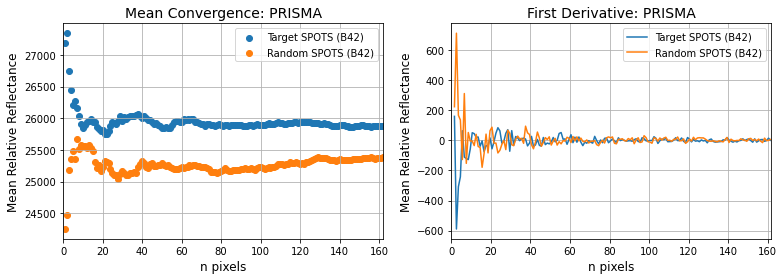

In [99]:
## Plot with stored values

## PLOT INDIVIDUAL BAND ##
saveIt = 0

target_band = 42 # band to plot, starting at 1

## PLOT 
target_band = target_band + 1
plt.figure(figsize=(11,4))

# plot cumulative means by pixel
plt.subplot(1,2,1)
plt.scatter(x_array[target_band], y_array[target_band], label = 'Target SPOTS (B{})'.format(target_band-1))
plt.scatter(stored_x_array[target_band], stored_y_array[target_band], label = 'Random SPOTS (B{})'.format(target_band-1))

plt.legend()
plt.xlabel('n pixels', size = 12)
plt.ylabel('Mean Relative Reflectance', size = 12)
plt.title('Mean Convergence: {}'.format(sensor), size = 14)
plt.grid()
plt.ylim()
plt.xlim(0,len(x_array[target_band]))

# plot first derivative, should converge at 0
plt.subplot(1,2,2)
plt.plot(x_p_array[target_band], y_p_array[target_band], label = 'Target SPOTS (B{})'.format(target_band-1))
plt.plot(stored_x_p_array[target_band], stored_y_p_array[target_band], label = 'Random SPOTS (B{})'.format(target_band-1))


plt.legend()
plt.xlabel('n pixels', size = 12)
plt.ylabel('Mean Relative Reflectance', size = 12)
plt.title('First Derivative: {}'.format(sensor), size = 14)
plt.grid()
plt.ylim()
plt.xlim(0,len(x_array[target_band]))

plt.tight_layout()

if saveIt:
    plt.savefig(parent_dir + '\outputs\\figures\pix_converge_Q7_random_vs_target_b{}.png'.format(target_band-1))

MOE_target_band = round(MOE_outputs[target_band])
print('Minimum n pix to reach a MOE of {} with z score of {} is: {} pixels'.format(MOE,z,MOE_target_band))

converge = MOE_target_band
spots_50m = round(converge/9, 1)
spots_100m = round(converge/20, 1)

print('Based on MOE - At least {} 50-meter spots, or {} 100-meter spots are needed'.format(spots_50m,spots_100m))